# Simple convolutional neural network for image classification: fashion-MNIST

This notebook shows a model for reaching 93.43% accuracy for fashion-mnist. I tried to create a simple conv net without extremly deep network. Furthermore I evaluate the generalization of the network for classify tradional MNIST at the end.

Some informations about the evaluation: I splitted the training set in train and validation. The testset of 10k images are used for final evaluation. I created 5 models with the same architecture but with random train/validation data. I only saved the weights of the model with best loss. Finally I used the models and evaluate them with the testset. The average accuracy of the 5 models is the final result of 93.43% accuracy.

#### Required data
You can find the dataset and further informations at Zalando:
- https://github.com/zalandoresearch/fashion-mnist
<br>Thanks to [Han](https://github.com/hanxiao) and [Kashif](https://github.com/kashif) for the great dataset.

The famous MNIST by Yann LeCun:
- http://yann.lecun.com/exdb/mnist

_______

If you have any questions or hints, please contact me through an issue. Thanks!<br>
Author: [Christopher Masch](https://github.com/cmasch)

_________

#### Parameter

In [1]:
#######################
# Dimension of images #
#######################
img_width  = 28
img_height = 28
channels   = 1

######################
# Parms for learning #
######################
batch_size = 250
num_epochs = 80
iterations = 5          # number of iterations
nb_augmentation = 2     # defines the number of additional augmentations of one image

####################
#       Data       #
####################
fashion_classes     = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'}

mnist_classes       = [i for i in range(10)]
num_classes         = 10

# Fashion-Mnist

#### Loading data
Using Tensorflow Dataset for loading Fashion-MNIST

In [2]:
import tensorflow_datasets as tfds

# Train
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Train Samples: 60000
Test Samples: 10000


#### Plot random samples

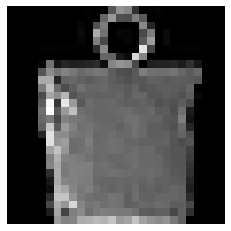

Target: Bag


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

idx = np.random.randint(len(X_train))
plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", fashion_classes[y_train[idx]])

#### Data augmentation (optional)
This method will increase the raw data by data augmentation of images. I just added rotation, horizontal flip and fill mode. Feel free to change this settings.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation
    image : raw image
    nb_augmentation: number of augmentations
    images: array with new images
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

#### Preprocess data
Processing of raw images:
- Scaling pixels between 0.0-1.0
- Add augmentated images

In [5]:
import tensorflow as tf

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: raw image
    targets: target label
    use_augmentation: True if augmentation should be used
    nb_of_augmentation: If use_augmentation=True, number of augmentations
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):
        
        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.
        
        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed: %i samples\n' % len(X))
    return np.array(X), tf.keras.utils.to_categorical(y)

In [6]:
X_train_shaped, y_train_shaped = preprocess_data(
    X_train, y_train, 
    use_augmentation=True, 
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped   = preprocess_data(X_test,  y_test)

*Preprocessing completed: 180000 samples

*Preprocessing completed: 10000 samples



#### Model definition

In [7]:
def create_model():
    """
    Creates a simple sequential model
    """
    
    cnn = tf.keras.Sequential()
    
    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))
    
    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))
    
    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    
    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

    return cnn

create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

##### Run training
Run training for number of iterations by random data for train/validation. The best model of each iteration will be saved as hdf5 checkpoint.

In [8]:
from sklearn.model_selection import train_test_split

histories = []

for i in range(0,iterations):
    print('Running iteration: %i' % i)
    
    # Saving the best checkpoint for each iteration
    filepath = "fashion_mnist-%i.hdf5" % i
    
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped,
                                                          test_size=0.2, random_state=42)
    
    cnn = create_model()
    history = cnn.fit(
        X_train_, y_train_,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_, y_val_),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
        ]
    )
    
    histories.append(history.history)

Running iteration: 0
Train on 144000 samples, validate on 36000 samples
Epoch 1/80
143250/144000 [============================>.] - ETA: 0s - loss: 0.5357 - accuracy: 0.8086
Epoch 00001: val_loss improved from inf to 0.32019, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 58s 404us/sample - loss: 0.5346 - accuracy: 0.8090 - val_loss: 0.3202 - val_accuracy: 0.8779
Epoch 2/80
143500/144000 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8734
Epoch 00002: val_loss improved from 0.32019 to 0.28545, saving model to fashion_mnist-0.hdf5
144000/144000 [==============================] - 14s 100us/sample - loss: 0.3458 - accuracy: 0.8734 - val_loss: 0.2854 - val_accuracy: 0.8915
Epoch 3/80


# Evaluation

#### Trainingscores for loss and accuracy for all checkpoints
Please remind that checkpoints will be saved by minimum loss.

In [9]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.10671850 loss / 0.96038610 acc
Validation: 	0.11881155 loss / 0.95765555 acc


#### Loss / accuracy of all models on testset
Determine loss and accuracy of all models.

In [10]:
test_loss = []
test_accs = []

for i in range(0,iterations):
    cnn_ = tf.keras.models.load_model("fashion_mnist-%i.hdf5" % i)
    
    score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i,score[0],score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

Running final test with model 0: 0.2065 loss / 0.9358 acc
Running final test with model 1: 0.2273 loss / 0.9310 acc
Running final test with model 2: 0.2150 loss / 0.9328 acc
Running final test with model 3: 0.2276 loss / 0.9326 acc
Running final test with model 4: 0.2188 loss / 0.9311 acc

Average loss / accuracy on testset: 0.2190 loss / 0.93266 acc
Standard deviation: (+-0.0079) loss / (+-0.0017) acc


##### Plotting accuracy and loss for each iteration

In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

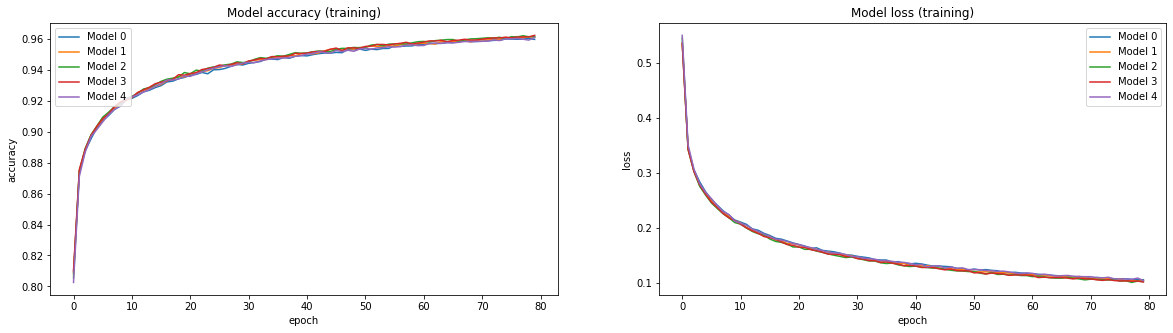

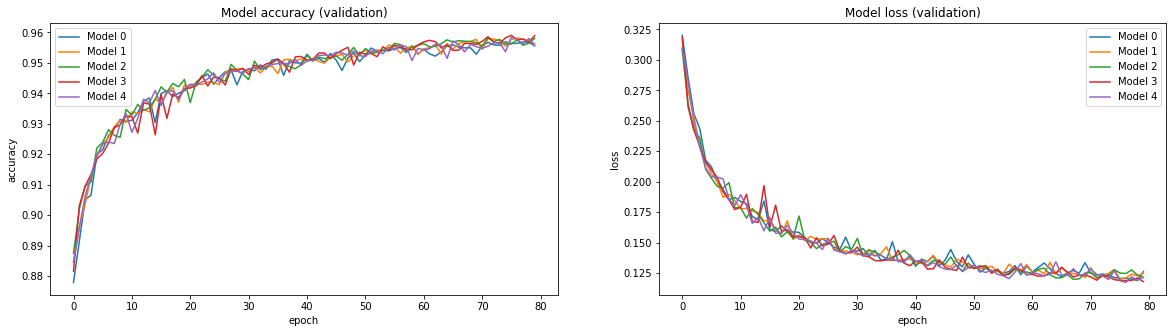

In [12]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

## Evaluation for one model

In [13]:
RUN = 0 # you can choose one of the different models trained above
model = create_model()
model.load_weights("fashion_mnist-%i.hdf5" % RUN)

##### Plotting accuracy and loss for one model

In [14]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

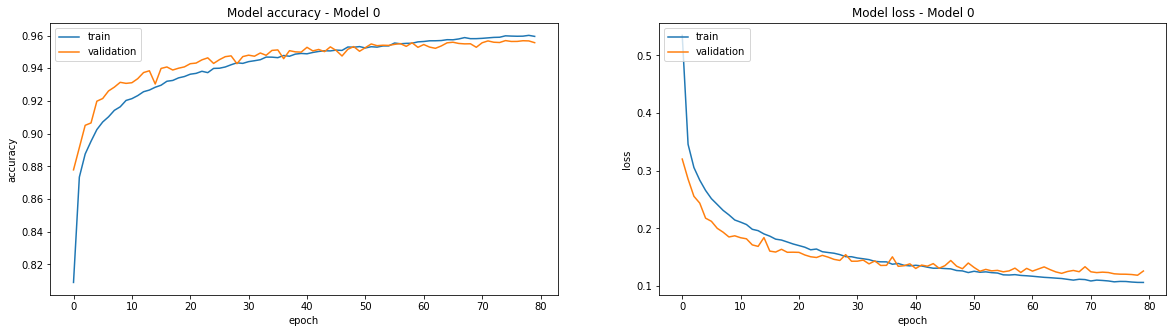

In [15]:
plot_train_val('Model %i' % RUN, histories[RUN])

##### Displaying results of random predictions

In [16]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row
    
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):
            
            elements = np.squeeze(np.argwhere(y_test==class_))
            random   = np.random.randint(len(elements))
            
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)
            
            x_reshape = X.reshape([1,img_height,img_width,channels])
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X), cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

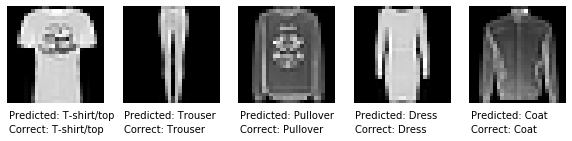

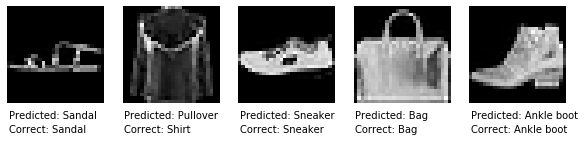

In [17]:
plot_sample_predictions(list(fashion_classes.values()), model, X_test_shaped, y_test)

##### Plotting confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

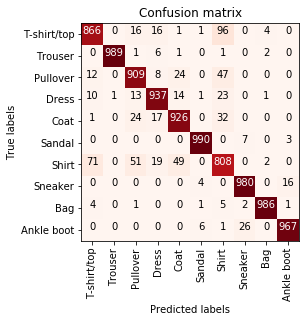

In [19]:
predictions = model.predict_classes(X_test_shaped, verbose=0)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(fashion_classes.values()))

##### Report of f1, precision and recall

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.90      0.91      0.90      1000
           3       0.93      0.94      0.94      1000
           4       0.91      0.93      0.92      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.81      0.80      1000
           7       0.97      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.97      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



____________
____________

# MNIST

#### Loading MNIST data

In [21]:
# Train
train_mnist = tfds.as_numpy(tfds.load("mnist", split="train", batch_size=-1))
X_train_mnist, y_train_mnist = train_mnist["image"], train_mnist["label"]

# Test
test_mnist = tfds.as_numpy(tfds.load("mnist", split="test", batch_size=-1))
X_test_mnist, y_test_mnist = test_mnist["image"], test_mnist["label"]

print("Train Samples:", len(X_train_mnist))
print("Test Samples:",  len(X_test_mnist))

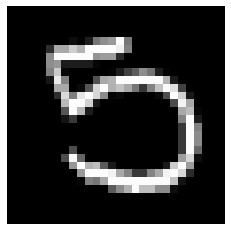

Target: 5


In [22]:
idx = np.random.randint(len(X_train_mnist))
plt.imshow(np.squeeze(X_train_mnist[idx]), cmap='gray')
plt.axis('off')
plt.show()

print("Target:", y_train_mnist[idx])

In [23]:
X_train_mnist_shaped, y_train_mnist_shaped = preprocess_data(
    X_train_mnist, y_train_mnist, 
    use_augmentation=True, 
    nb_of_augmentation=nb_augmentation
)

X_test_mnist_shaped, y_test_mnist_shaped = preprocess_data(X_test_mnist, y_test_mnist)

*Preprocessing completed: 180000 samples

*Preprocessing completed: 10000 samples



#### Train model on MNIST

In [24]:
cnn_mnist = create_model()

X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_mnist_shaped, y_train_mnist_shaped,
                                                      test_size=0.2, random_state=42)

history_mnist_raw = cnn_mnist.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_, y_val_),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("mnist.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
    ]
)

Train on 144000 samples, validate on 36000 samples
Epoch 1/80
143250/144000 [============================>.] - ETA: 0s - loss: 0.2831 - accuracy: 0.9130
Epoch 00001: val_loss improved from inf to 0.06758, saving model to mnist.hdf5
144000/144000 [==============================] - 16s 108us/sample - loss: 0.2823 - accuracy: 0.9132 - val_loss: 0.0676 - val_accuracy: 0.9792
Epoch 2/80
143250/144000 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9724
Epoch 00002: val_loss improved from 0.06758 to 0.04881, saving model to mnist.hdf5
144000/144000 [==============================] - 15s 103us/sample - loss: 0.0913 - accuracy: 0.9725 - val_loss: 0.0488 - val_accuracy: 0.9849
Epoch 3/80


### Evaluation

#### Final test

In [25]:
mnist_model = tf.keras.models.load_model("mnist.hdf5")

score = mnist_model.evaluate(X_test_mnist_shaped, y_test_mnist_shaped, verbose=0)
print('Running final test: %0.4f loss / %0.4f acc' % (score[0], score[1]))

Running final test: 0.0248 loss / 0.9941 acc


#### Plotting some metrics

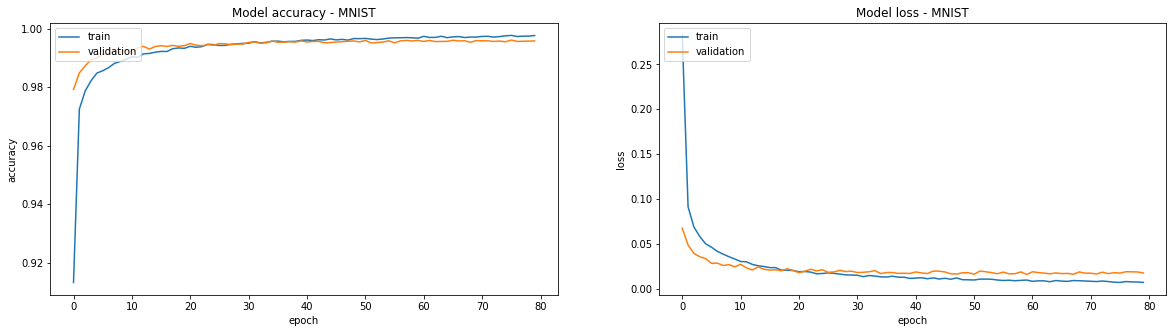

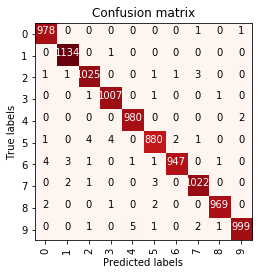

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [26]:
pred  = mnist_model.predict_classes(X_test_mnist_shaped, verbose=0)

plot_train_val('MNIST', history_mnist_raw.history)
plot_confusion_matrix(confusion_matrix(y_true=y_test_mnist, y_pred=pred), mnist_classes)
print(classification_report(y_true=y_test_mnist, y_pred=pred))

#### Examples

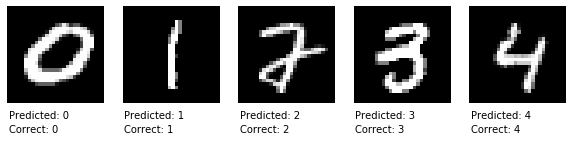

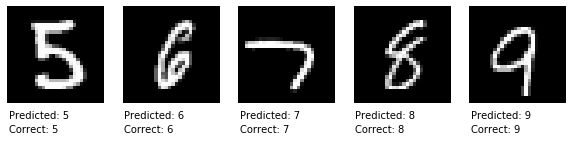

In [27]:
plot_sample_predictions(mnist_classes, mnist_model, X_test_mnist_shaped, y_test_mnist)